# Testing the effect of two scenarios, for various method candidates
- Opinion vectors are orthogonal, and another orthogonal opinion vector is added (e.g. 2→3)
- Opinion vectors are duplicated (e.g. 2→4)

In [14]:
# import sys
# sys.path.append('..')

import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
import networkx as nx

import random

import scipy.stats as st
import torch
import torch_geometric

In [15]:
def SBM_graph(n_comms, p_out, intercon, nodes_per_comm):
    """
    Generate a graph with SBM with given parameters. 
    n_comms: int, number of communities
    p_out: float, probability that each node will connect to a node in a different community
    intercon: int, number of other communities each community is connected to
    """
    p = utils.ideo_make_p(n_comms=n_comms, p_out=p_out, intercon=intercon)
    G = utils.ideo_make_G(p=p, n_comms=n_comms, nodes_per_comm=nodes_per_comm)
    return G

In [16]:
polarization_metrics = [nvd.pairwise_average, nvd.avg_dist_to_mean, nvd.PCA_manifold, nvd.MDS_euclidean_manifold, nvd.total_variation]
metric_names = ['Avg pairwise dist', 'Avg dist to mean', 'PCA', 'Euclidean MDS', 'Total variation']

## Adding orthogonal opinions

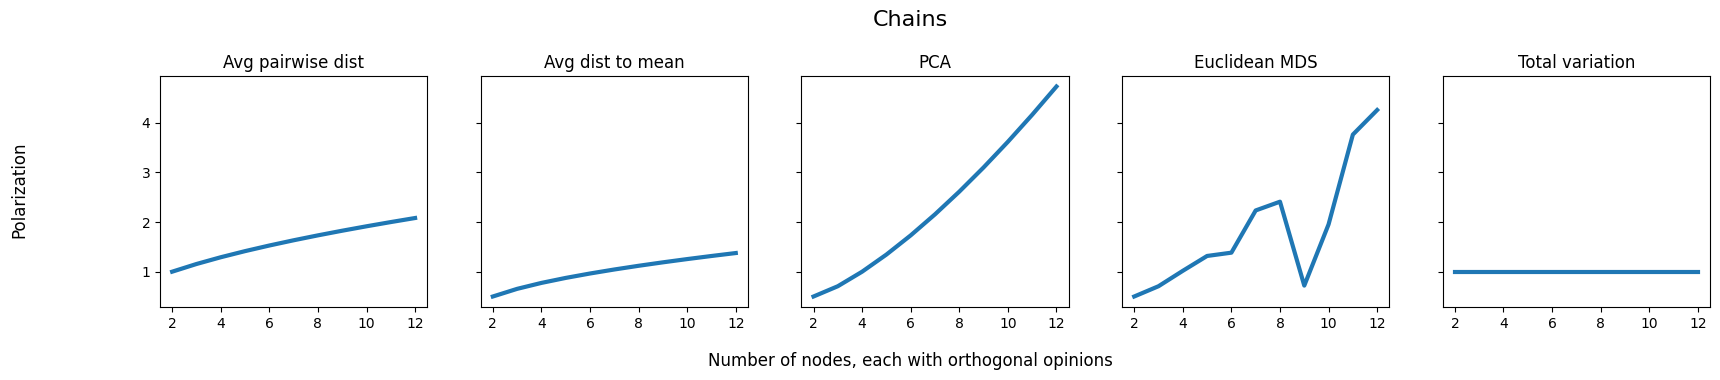

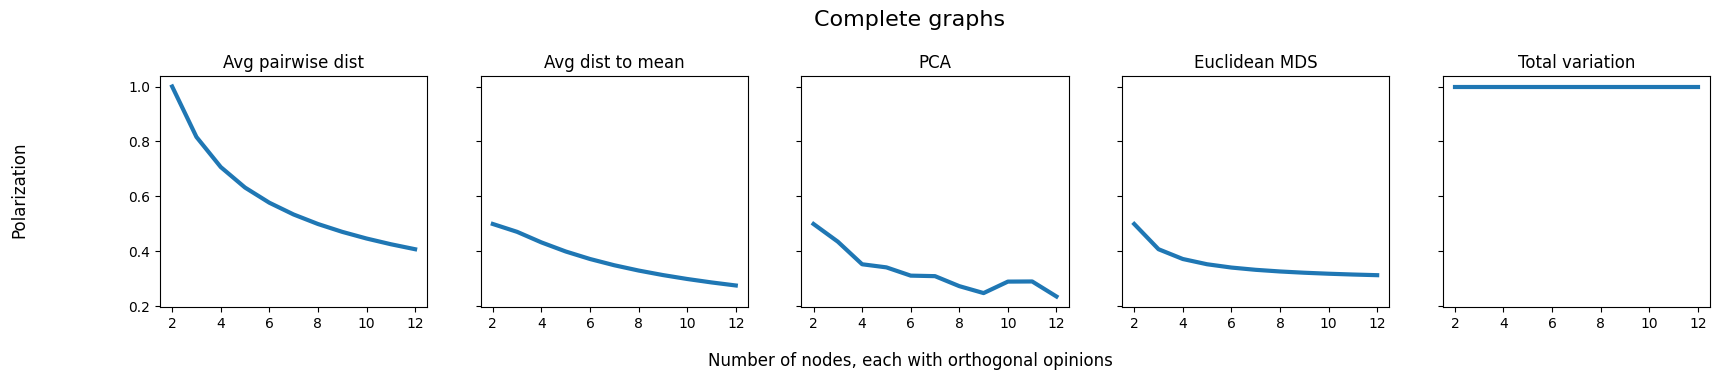

In [17]:
num_opinions_range = range(2, 13)

for graph_name, graph_type in [('Chains', nx.path_graph), 
                               ('Complete graphs', nx.complete_graph)]:
    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)
    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        polarizations = []
        for num_opinions in num_opinions_range:
            G = graph_type(num_opinions)
            o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
            tensor = nvd.make_tensor(G, o)

            polarization = polarization_metric(tensor)
            polarizations.append(polarization)
        ax[i].plot(num_opinions_range, polarizations, lw=3)
        ax[i].set_title(metric_name)
    fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.1)
    fig.supylabel('Polarization', x=0.05)
    fig.suptitle(graph_name, y=1.1, fontsize=16)

C:\Users\Christian Weidemann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Christian Weidemann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\Christian Weidemann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Christian Weidemann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

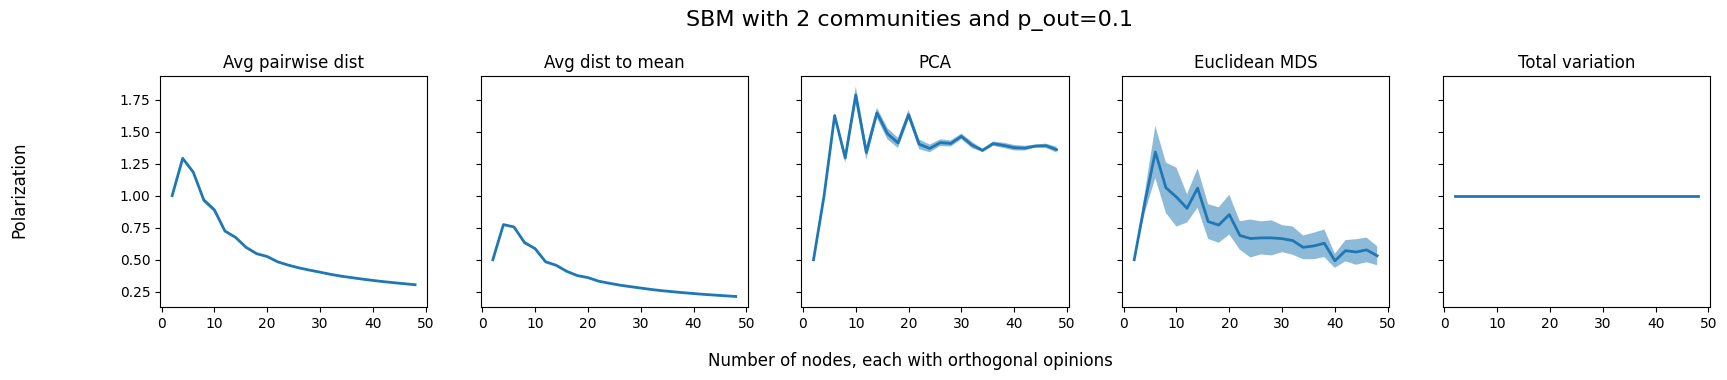

In [18]:
num_opinions_range = range(2, 50, 2)
num_runs = 13

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
    pols = np.array([])
    pol_lower_conf = np.array([])
    pol_higher_conf = np.array([])

    for num_opinions in num_opinions_range:
        run_pols = np.zeros(num_runs)
        for run in range(num_runs):
            # Generating G with SBM
            p = utils.ideo_make_p(n_comms=2, p_out=0.1, intercon=1)
            G = utils.ideo_make_G(p=p, n_comms=2, nodes_per_comm=num_opinions//2)
            assert len(G) == num_opinions, f'len(G)={len(G)}; num_opinions={num_opinions}'

            # if G is disconnected, connect all components
            if not nx.is_connected(G):
                components = list(nx.connected_components(G))
                for x in range(len(components)-1):
                    G.add_edge(random.choice(list(components[x])), random.choice(list(components[x+1])))
            assert nx.is_connected(G)

            o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
            tensor = nvd.make_tensor(G, o)
            polarization = polarization_metric(tensor)
            run_pols[run] = polarization

        pols = np.append(pols, np.mean(run_pols))

        # Calculate the 95% confidence intervals
        lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
        pol_lower_conf = np.append(pol_lower_conf, lower_conf)
        pol_higher_conf = np.append(pol_higher_conf, higher_conf)

    # ax[i].errorbar(num_opinions_range, polarizations, polarizations_std, linestyle='None', marker='o', markersize=5, capsize=5)

    ax[i].plot(num_opinions_range, pols, lw=2)
    ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)

    ax[i].set_title(metric_name)

fig.supxlabel('Number of nodes, each with orthogonal opinions', y=-0.1)
fig.supylabel('Polarization', x=0.05)
fig.suptitle('SBM with 2 communities and p_out=0.1', y=1.1, fontsize=16);

## Converting neutral community to third orthogonal opinion

### In SBM graphs with 3 communities

### In chains

Avg pairwise dist: 1.41 -> 1.15
Avg dist to mean: 0.71 -> 0.65
PCA: 0.71 -> 0.71
Euclidean MDS: 0.71 -> 0.71
Total variation: 0.67 -> 1.00


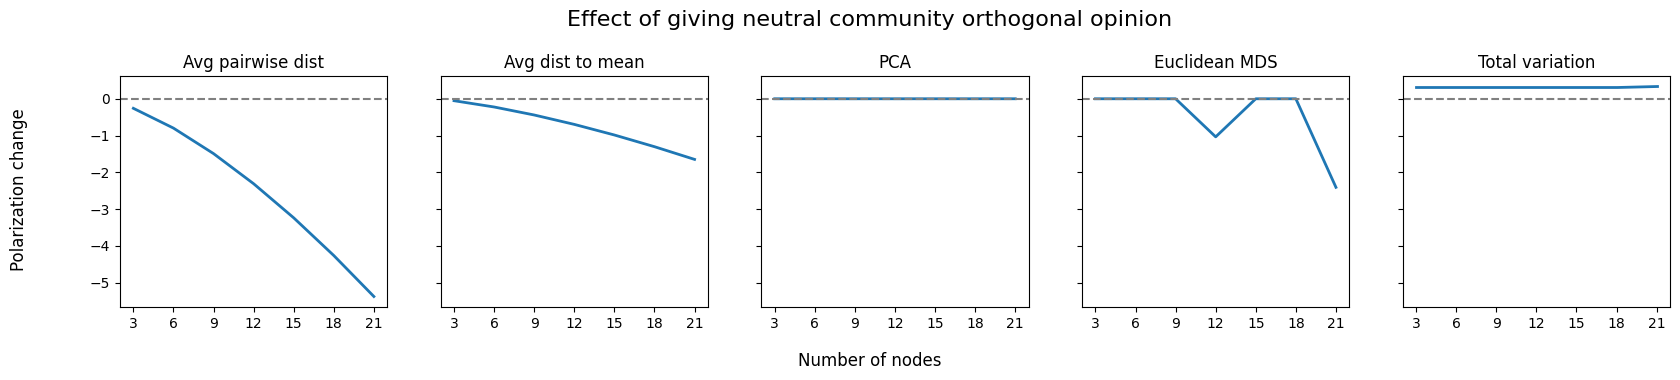

In [45]:
num_nodes_range = range(3, 22, 3)
assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

opinion_types = ['neutral', 'third opinion']

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.array([])

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        neutral_polarization = 0
        third_polarization = 0
        
        # Generating G as chain graph
        G = nx.path_graph(num_nodes)

        # neutral opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                            np.array([(0,0)]*nodes_per_comm),
                                                            np.array([(0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        neutral_polarization = polarization_metric(tensor)

        # third opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                    np.array([(0,1,0)]*nodes_per_comm),
                                                                    np.array([(0,0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        third_polarization = polarization_metric(tensor)

        difference = third_polarization - neutral_polarization
        
        means_diffs = np.append(means_diffs, difference)
        
        # Print before and after polarizations for num_nodes == 3
        if num_nodes == 3:
            print(f"{metric_name}: {neutral_polarization:.2f} -> {third_polarization:.2f}")                                                 

    ax[i].plot(num_nodes_range, means_diffs, lw=2)

    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

### In complete graphs

Avg pairwise dist: 0.82 -> 0.82
Avg dist to mean: 0.41 -> 0.47
PCA: 0.41 -> 0.44
Euclidean MDS: 0.41 -> 0.41
Total variation: 0.67 -> 1.00


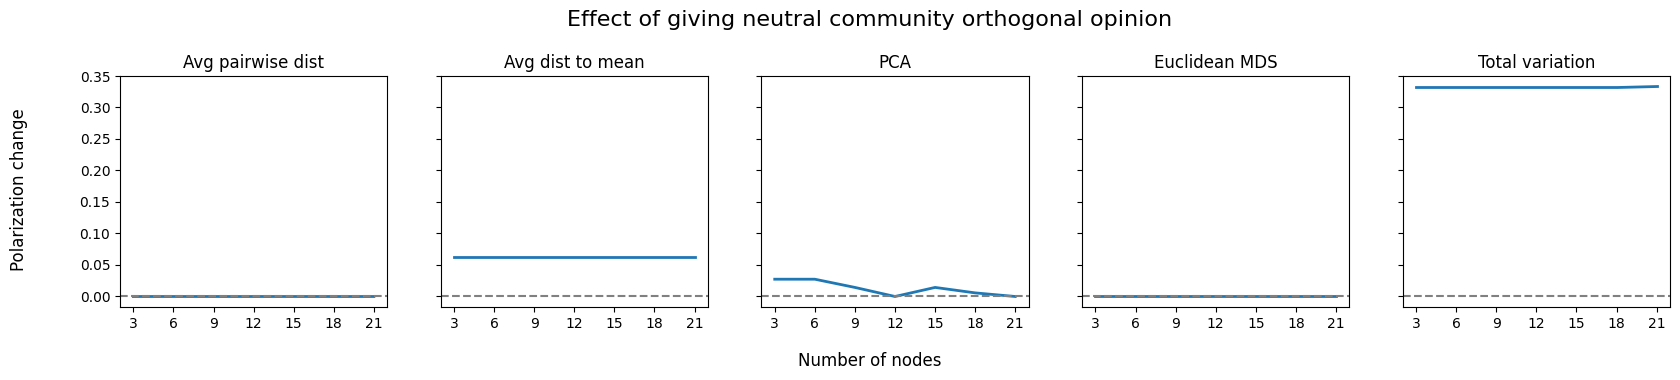

In [35]:
num_nodes_range = range(3, 22, 3)
assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

opinion_types = ['neutral', 'third opinion']

num_runs = 20

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.array([])

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        neutral_polarization = 0
        third_polarization = 0
        
        # Generating G as complete graph
        G = nx.complete_graph(num_nodes)

        # neutral opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                            np.array([(0,0)]*nodes_per_comm),
                                                            np.array([(0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        neutral_polarization = polarization_metric(tensor)

        # third opinion polarization
        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                    np.array([(0,1,0)]*nodes_per_comm),
                                                                    np.array([(0,0,1)]*nodes_per_comm))))
        tensor = nvd.make_tensor(G, o)
        third_polarization = polarization_metric(tensor)

        # Print before and after polarizations for num_nodes == 3
        if num_nodes == 3:
            print(f"{metric_name}: {neutral_polarization:.2f} -> {third_polarization:.2f}")

        difference = third_polarization - neutral_polarization
        
        means_diffs = np.append(means_diffs, difference)                                                 

    ax[i].plot(num_nodes_range, means_diffs, lw=2)

    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

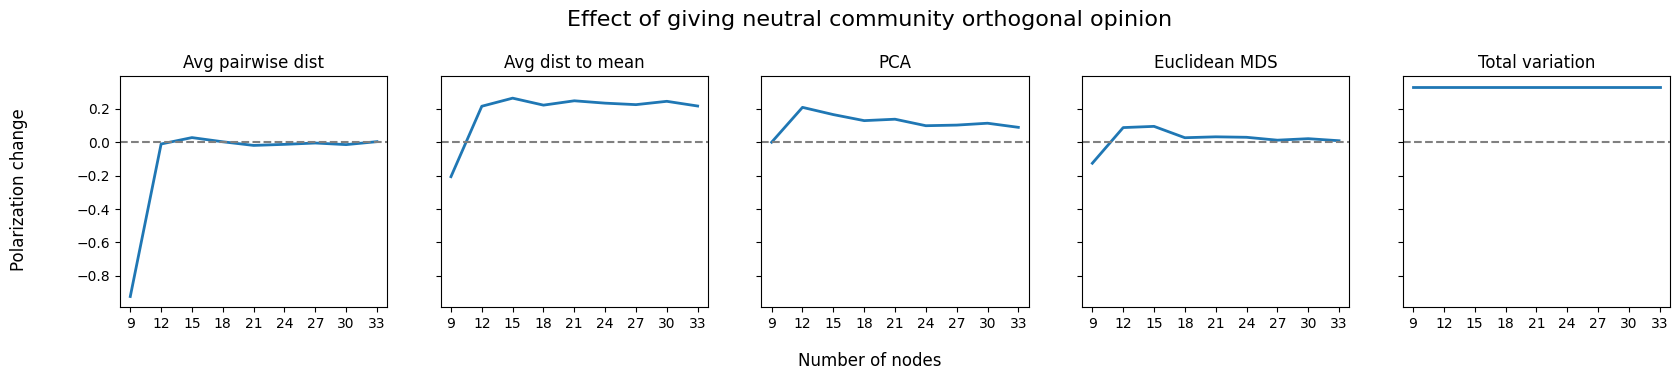

In [109]:
num_nodes_range = range(9, 34, 3)

opinion_types = ['neutral', 'third opinion']

num_runs = 20

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    means_diffs = np.array([])

    for num_nodes in num_nodes_range:

        run_diffs = np.zeros(num_runs)
        
        for run in range(num_runs):

            nodes_per_comm = num_nodes//3
        
            neutral_polarization = 0
            third_polarization = 0
            
            # Generating G with SBM
            G = SBM_graph(n_comms=3, p_out=0.1, intercon=2, nodes_per_comm=nodes_per_comm)

            # neutral opinion polarization
            o = pd.DataFrame(columns=['o0', 'o1'], data=np.vstack((np.array([(1,0)]*nodes_per_comm),
                                                                np.array([(0,0)]*nodes_per_comm),
                                                                np.array([(0,1)]*nodes_per_comm))))
            tensor = nvd.make_tensor(G, o)
            neutral_polarization = polarization_metric(tensor)

            # third opinion polarization
            o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))
            tensor = nvd.make_tensor(G, o)
            third_polarization = polarization_metric(tensor)

            difference = third_polarization - neutral_polarization
            run_diffs[run] = difference
        
        # Print before and after polarizations for num_nodes == 3
        if num_nodes == 3:
            print(f"{metric_name}: {neutral_polarization:.2f} -> {third_polarization:.2f}") 

        means_diffs = np.append(means_diffs, np.mean(run_diffs))                                                 

    ax[i].plot(num_nodes_range, means_diffs, lw=2)

    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

fig.supxlabel('Number of nodes', y=-0.1)
fig.supylabel('Polarization change', x=0.07)
fig.suptitle('Effect of giving neutral community orthogonal opinion', y=1.1, fontsize=16);

## Duplicating one or more opinion vectors

Note: for some reason it makes no difference whether I duplicate one or 3 opinions, is it a bug?

### On chain graphs

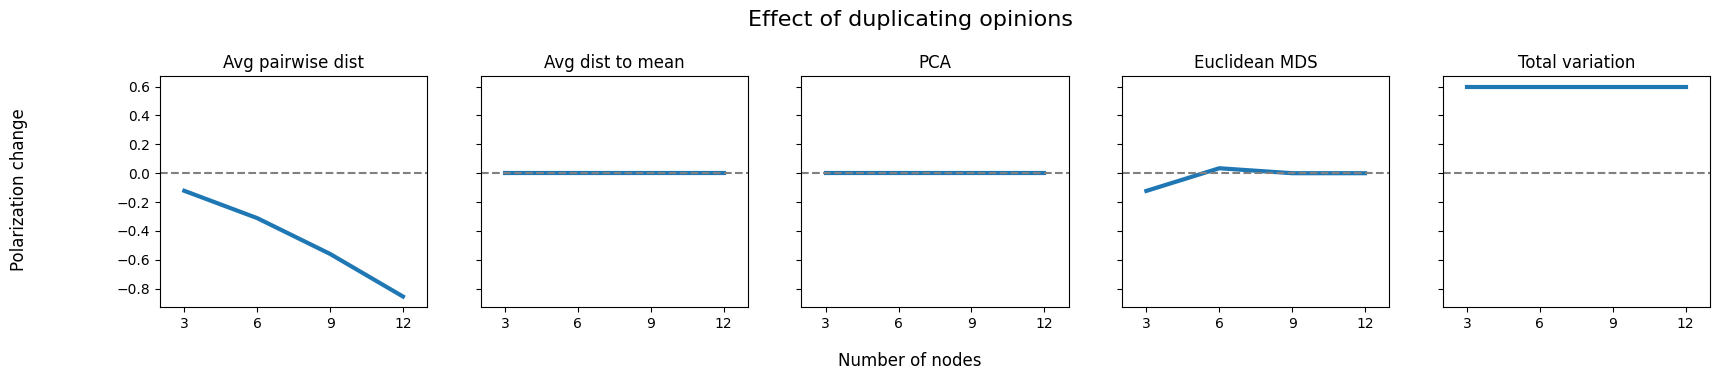

In [108]:
num_nodes_range = range(3, 13, 3)

assert all([num_nodes % 3 == 0 for num_nodes in num_nodes_range]), f'num_nodes not divisible by 3'

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    unique_polarizations = []
    duplicate_polarizations = []
    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = nx.path_graph(num_nodes)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)
        unique_polarizations.append(unique_polarization)
        duplicate_polarizations.append(duplicate_polarization)

    ax[i].plot(num_nodes_range, differences, lw=3)
    # ax[i].plot(num_nodes_range, unique_polarizations, lw=2, color='C0')
    # ax[i].plot(num_nodes_range, duplicate_polarizations, lw=2, color='C1')
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

### On complete graphs

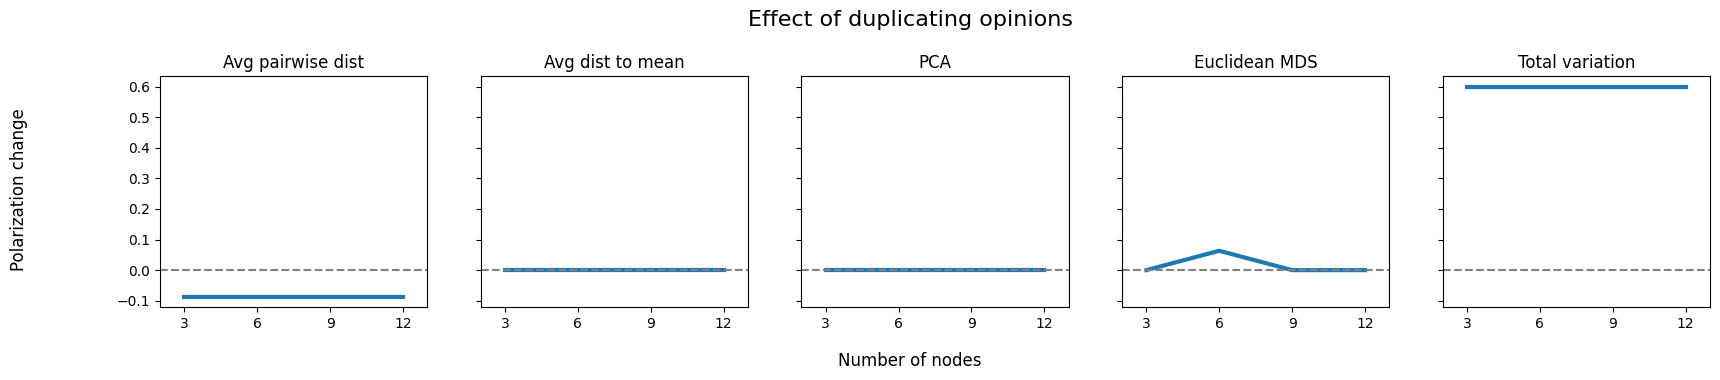

In [106]:
num_nodes_range = range(3, 13, 3)

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = nx.complete_graph(num_nodes)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)

    ax[i].plot(num_nodes_range, differences, lw=3)
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

### On SBM network with 3 communities, p_out=0.1

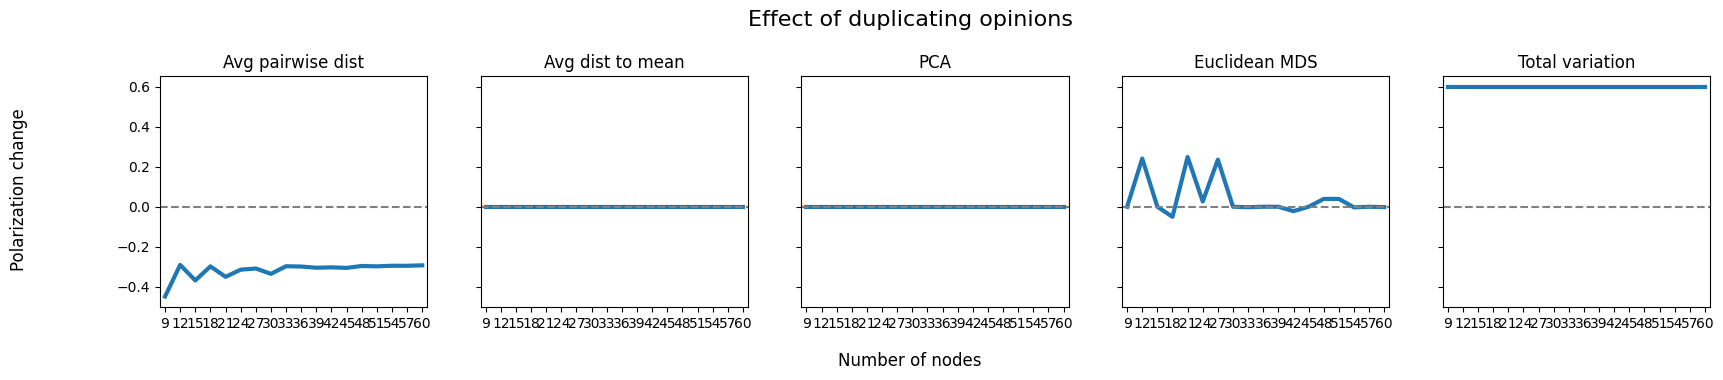

In [107]:
num_nodes_range = range(9, 63, 3)

fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):

    differences = []

    for num_nodes in num_nodes_range:

        nodes_per_comm = num_nodes//3
    
        unique_polarization = 0
        duplicate_polarization = 0
        
        G = SBM_graph(n_comms=3, p_out=0.1, intercon=2, nodes_per_comm=nodes_per_comm)

        o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                        np.array([(0,1,0)]*nodes_per_comm),
                                                                        np.array([(0,0,1)]*nodes_per_comm))))

        tensor = nvd.make_tensor(G, o)
        unique_polarization = polarization_metric(tensor)

        # duplicate last column of o
        dup_o = pd.concat([o, o], axis=1)
        # dup_o.columns = ['o0', 'o1', 'o2', 'o3']
        
        dup_tensor = nvd.make_tensor(G, dup_o)
        duplicate_polarization = polarization_metric(dup_tensor)

        difference = duplicate_polarization - unique_polarization
        differences.append(difference)

    ax[i].plot(num_nodes_range, differences, lw=3)
    ax[i].set_xticks(num_nodes_range)
    ax[i].set_xlim(num_nodes_range[0]-1, num_nodes_range[-1]+1)
    ax[i].set_title(metric_name)
    ax[i].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='gray', linestyles='dashed')

    fig.supxlabel('Number of nodes', y=-0.1)
    fig.supylabel('Polarization change', x=0.05)
    fig.suptitle(f'Effect of duplicating opinions', y=1.1, fontsize=16);

In [24]:
def plot_test(num_opinions_range, n_nodes, n_comms, p_out, intercon, polarization_metrics, metric_names, plot_title, plot_xlabel, plot_ylabel, opinion_type, num_runs=10):
    """
    Plot the polarization of a SBM graph with different number of opinions and different polarization metrics.
    
    num_opinions_range: range, range of number of opinions to test
    num_runs: int, number of runs random initializations for each test
    opinion_types: list, list of opinion types to test
    """

    if not n_nodes % n_comms == 0:
        raise ValueError(f'n_nodes={n_nodes} not divisible by n_comms={n_comms}')
    nodes_per_comm = n_nodes//n_comms

    fig, ax = plt.subplots(1, len(polarization_metrics), figsize=(4*len(polarization_metrics), 3), sharey=True)

    for i, (metric_name, polarization_metric) in enumerate(zip(metric_names, polarization_metrics)):
        pols = np.array([])
        pol_lower_conf = np.array([])
        pol_higher_conf = np.array([])

        for num_opinions in num_opinions_range:

            run_pols = np.zeros(num_runs)

            for run in range(num_runs):

                G = SBM_graph(n_nodes, n_comms, p_out, intercon, nodes_per_comm)
    

                if opinion_type == 'unique':
                    o = pd.DataFrame(columns=['o'+str(i) for i in range(num_opinions)], data=np.identity(num_opinions))
                elif opinion_type == 'orthogonal':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                                                                np.array([(0,1,0)]*nodes_per_comm),
                                                                                np.array([(0,0,1)]*nodes_per_comm))))
                elif opinion_type == 'correlated':
                    o = pd.DataFrame(columns=['o0', 'o1', 'o2'], data=np.vstack((np.array([(1,1,0)]*nodes_per_comm),
                                                                                np.array([(0,1,1)]*nodes_per_comm),
                                                                                np.array([(1,0,1)]*nodes_per_comm))))
                else:
                    raise ValueError(f'opinion_type={opinion_type} not valid. Must be one of "unique", "orthogonal", "correlated".')

                tensor = nvd.make_tensor(G, o)
                Linv = nvd._Linv(tensor)

                polarization = polarization_metric(tensor, Linv=Linv)
                run_pols[run] = polarization

            # Calculate the mean polarization of num_runs runs
            pols = np.append(pols, np.mean(run_pols))  

            # Calculate the 95% confidence intervals of the mean polarization
            lower_conf, higher_conf = st.t.interval(0.95, len(run_pols)-1, loc=np.mean(run_pols), scale=st.sem(run_pols))
            pol_lower_conf = np.append(pol_lower_conf, lower_conf)
            pol_higher_conf = np.append(pol_higher_conf, higher_conf)

        ax[i].plot(num_opinions_range, pols, lw=2)
        ax[i].fill_between(num_opinions_range, pol_higher_conf, pol_lower_conf, alpha=.5, linewidth=0)  # Shade the 95% confidence interval around the mean
        ax[i].set_title(metric_name)

    fig.suptitle(plot_title, y=1.1, fontsize=16)
    fig.supxlabel(plot_xlabel, y=-0.1)
    fig.supylabel(plot_ylabel, x=0.05);

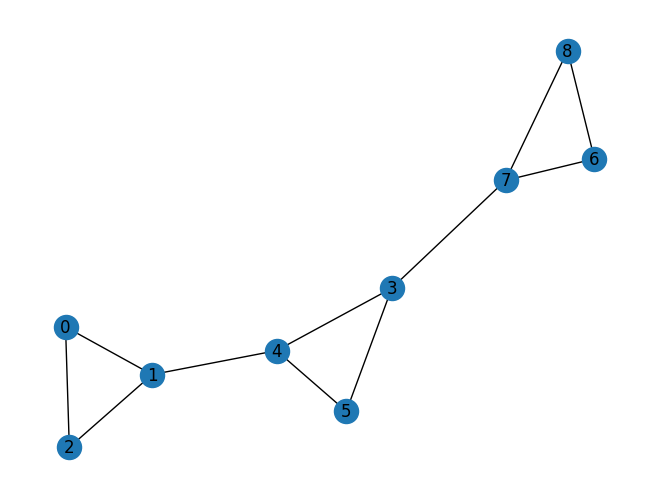

In [82]:
nodes_per_comm=3
G = SBM_graph(n_comms=3, p_out=0.1, intercon=2, nodes_per_comm=nodes_per_comm)
nx.draw(G, with_labels=True)